# A New Way to BOW Analysis & Feature Engineering

This is the Analysis work done for the Medium story - https://medium.com/@prateekkrjain/a-new-way-to-bow-analysis-feature-engineering-part1-e012eba90ef

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
import re
import json
import nltk
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.stats import mannwhitneyu

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
import seaborn as sns

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer

In [6]:
# we will be using RedditScore package to extract some of the features from tweets like
# 1) Split a hashtag into words as it may contain useful words
# 2) Get the title from the URLs as that may too contain some words which will help to classify the tweets
!pip install git+https://github.com/crazyfrogspb/RedditScore

  Cloning https://github.com/crazyfrogspb/RedditScore to /tmp/pip-req-build-vhushb2h
  Running command git clone -q https://github.com/crazyfrogspb/RedditScore /tmp/pip-req-build-vhushb2h
     |████████████████████████████████| 92kB 394kB/s eta 0:00:01
     |████████████████████████████████| 225kB 1.3MB/s eta 0:00:01
     |████████████████████████████████| 194kB 3.2MB/s eta 0:00:01
  Created wheel for redditscore: filename=redditscore-0.7.3-cp36-none-any.whl size=7649187 sha256=fe532e43004f4d7938c8879196335227c4ec25d14f5c241a29a0ebfde1e0910e
  Stored in directory: /tmp/pip-ephem-wheel-cache-gx574sen/wheels/2b/ab/36/38f5958052820791cfd8e2124dce8895312f0792f70b7282b1
  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7099 sha256=93de3ecc911b391b469abd85faf7e5078d45f85383472c5e947f0c00a6c164f1
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built redditscore adjustText


# Load Data

In [7]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")[['target', 'text']]
print("Size of the data: ", train_df.shape[0])
train_df.head(2)

Size of the data:  7613


,target,text
0,1,Our Deeds are the Reason of this #earthquake M...
1,1,Forest fire near La Ronge Sask. Canada


In [8]:
# print sample tweets
train_df.iloc[:10, 1].values

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
       '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
       '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
       "I'm on top of the hill and I can see a fire in the woods...",
       "There's an emergency evacuation happening now in the building across the street",
       "I'm afraid that the tornado is coming to our area..."],
      dtype=object)

In [9]:
# check the values in the target valiable
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

# Prepare Features

In [98]:
# the preprocessor function for CountVectorizer
import re
import gensim
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

from collections import defaultdict

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def preprocessor(text, custom_stopwords=[]):

    text = str(text).lower()
    
    # remove URLs
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(regex, ' ', text)
    
    # split the sentence into tokens
    tokens = word_tokenize(text)

    # remove any numeric character
    tokens = [re.sub(r'[0-9-]+', '', token) for token in tokens] 
    
    # remove stopwords
    tokens = [token for token in tokens if token not in stop_words \
              and token not in custom_stopwords]

    # remove stop words or any token having size <3
    tokens = [token for token in tokens if len(token) >= 3]
    
    # get pos tags and lemmatize tokens
    pos_tags = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(token, tag_map[tag]) for token, tag in zip(tokens, pos_tags)]
#     tokens = [stemmer.stem(token) for token, tag in zip(tokens, pos_tags)]
 
    return tokens
#     return " ".join(tokens)

In [99]:
print(train_df['text'][0])
preprocessor(train_df['text'][0])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive']

In [100]:
data_words = [preprocessor(txt) for txt in train_df['text']]
print(data_words[0])

['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive']


In [101]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=1) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=1)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def get_bigrams(words):
    return bigram_mod[words]
    
def get_trigrams(words):
    return trigram_mod[get_bigrams(words)]
    
# See trigram example
for i in range(20):
    print(get_trigrams(data_words[i]))

['deed', 'reason', 'earthquake', 'may_allah', 'forgive']
['forest_fire', 'near', 'ronge', 'sask', 'canada']
['resident', 'asked', "'shelter", 'place', 'notified', 'officer', 'evacuation', 'shelter', 'place', 'order', 'expected']
['people', 'receive', 'wildfire', 'evacuation_order', 'california']
['got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfire', 'pours', 'school']
['rockyfire', 'update', 'california', 'hwy_closed', 'direction', 'due', 'lake', 'county_fire', 'cafire', 'wildfire']
['flood_disaster', 'heavy_rain', 'cause', 'flash_flooding', 'street', 'manitou', 'colorado', 'spring', 'area']
['top', 'hill', 'see_fire', 'wood', '...']
['emergency_evacuation', 'happening', 'building', 'across', 'street']
['afraid', 'tornado', 'coming', 'area_...']
['three_people', 'died_heat', 'wave', 'far']
['haha', 'south_tampa', 'getting', 'flooded', 'hah', 'wait', 'second', 'live', 'south_tampa', 'gon', 'gon', 'fvck', 'flooding']
['raining', 'flooding', 'florida', 'tampabay', 'tampa', 'day',

In [102]:
# process data
train_df['processed'] = train_df['text'].apply(preprocessor).apply(get_trigrams).apply(" ".join)
train_df.head(5)

,target,text,processed
0,1,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may_allah forgive
1,1,Forest fire near La Ronge Sask. Canada,forest_fire near ronge sask canada
2,1,All residents asked to 'shelter in place' are ...,resident asked 'shelter place notified officer...
3,1,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation_order calif...
4,1,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...


In [103]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

In [104]:
count_vectorizer = CountVectorizer(min_df=2, max_df=.8).fit(train_df['processed'])
print(f"Number of words: {len(count_vectorizer.get_feature_names())}")

Number of words: 7871


In [105]:
overall_data = train_df.groupby('target', as_index=False).agg({'processed': ' '.join})

overall_count = count_vectorizer.transform(overall_data['processed'])
ctfidf_vectorizer = CTFIDFVectorizer().fit(overall_count, n_samples=len(train_df['target']))

### Split data into train and test

In [106]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df[['processed', 'target']], train_df['target'], test_size=0.2, \
                                                    stratify=train_df['target'], random_state=42)

X_train.reset_index(inplace=True)
Y_train = Y_train.reset_index()['target']

X_test.reset_index(inplace=True)
Y_test = Y_test.reset_index()['target']

### Convert to Class based TF-IDF

In [107]:
X_train_grouped = X_train.groupby('target', as_index=False).agg({'processed': ' '.join})
X_train_grouped.head(2)

,target,processed
0,0,god kingdom heavenly gov't rule people earth a...
1,1,sassy_city girl_country hunk_stranded smoky_mo...


In [108]:
train_count = count_vectorizer.transform(X_train_grouped['processed'])
train_ctfidf = ctfidf_vectorizer.transform(train_count)

In [109]:
X_test_grouped = X_test.groupby('target', as_index=False).agg({'processed': ' '.join})
X_test_grouped.head(2)

,target,processed
0,0,theeconomist step one_get mass_murderer portra...
1,1,ûïlittle boyû affected people_hiroshima ûò...


In [110]:
test_count = count_vectorizer.transform(X_test_grouped['processed'])
test_ctfidf = ctfidf_vectorizer.transform(test_count)

In [111]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(train_ctfidf, test_ctfidf)

array([[0.73598332, 0.43337741],
       [0.49131708, 0.65654616]])

In [112]:
def get_distance(fts1, fts2, ft_names):
    norm1 = sum([val**2 for val in fts1]) ** 0.5
    norm2 = sum([val**2 for val in fts2]) ** 0.5
    norm = norm1 * norm2
    cos_sim = [(ft_name, (x*y)/norm) for ft_name, (x,y) in zip(ft_names, zip(fts1, fts2))]
    return [(x, y) for x, y in cos_sim if y>0]

In [113]:
train_ctfidf[0].toarray()

array([[0.00000000e+00, 2.31454503e-04, 0.00000000e+00, ...,
        3.11219998e-04, 6.31750176e-05, 1.80204158e-04]])

In [114]:
ft_names = count_vectorizer.get_feature_names()

diff_fts = get_distance(train_ctfidf[0].toarray()[0], test_ctfidf[0].toarray()[0], ft_names)

print(f"Cosine similarity: {sum([_ for x, _ in diff_fts])}")

# diff_fts = list(zip(ft_names, get_distance(train_ctfidf[0].toarray()[0], test_ctfidf[0].toarray()[0])))

diff_fts = sorted(diff_fts, key=lambda x: x[1], reverse=True)
print(f"Number of common features found: {len(diff_fts)}")
print(diff_fts[:50])

Cosine similarity: 0.7359833189217663
Number of common features found: 2274
[('û_', 0.02126397752690059), ('amp', 0.017041381305877203), ('like', 0.013397988455063006), ('get', 0.010841468572518687), ('one', 0.010039453380689189), ('re', 0.007272799534577729), ('know', 0.006984928727741882), ('see', 0.0066407438339111235), ('lol', 0.006265969723445783), ('time', 0.005592685101235176), ('day', 0.005582964433048679), ('got', 0.005289346042836847), ('love', 0.005157828831951273), ('back', 0.005132404152123383), ('would', 0.0050223297102092645), ('good', 0.004769982742118462), ('going', 0.004698456657514774), ('let', 0.004410725120335489), ('new', 0.004364609210497196), ('need', 0.004351918076958886), ('ve', 0.004151599690972169), ('come', 0.003863738396425863), ('say', 0.0037354184065750075), ('want', 0.003611476639405993), ('ll', 0.0035508556392941405), ('people', 0.003501402938558607), ('screaming', 0.0034652919820693713), ('thing', 0.003363278789314966), ('body_bag', 0.0032664004014220

In [115]:
ft_names = count_vectorizer.get_feature_names()

diff_fts = get_distance(train_ctfidf[1].toarray()[0], test_ctfidf[1].toarray()[0], ft_names)

print(f"Cosine similarity: {sum([_ for x, _ in diff_fts])}")

# diff_fts = list(zip(ft_names, get_distance(train_ctfidf[0].toarray()[0], test_ctfidf[0].toarray()[0])))

diff_fts = sorted(diff_fts, key=lambda x: x[1], reverse=True)
print(f"Number of common features found: {len(diff_fts)}")
print(diff_fts[:50])

Cosine similarity: 0.6565461580423767
Number of common features found: 1868
[('û_', 0.037051940122491904), ('fire', 0.015062266378944507), ('amp', 0.01237084928329104), ('news', 0.008884034523524023), ('death', 0.007052150858809633), ('via', 0.005581894925658428), ('flood', 0.004931066536461252), ('car', 0.004895618057193219), ('report', 0.004512905629593109), ('today', 0.004474518230762579), ('latest_home_razed_northern', 0.004153296472459769), ('storm', 0.004035738628052109), ('one', 0.004027781600254775), ('family_sue_legionnaire_family', 0.003963159439179722), ('wreckage_', 0.0037429839147808484), ('people', 0.003607569779203045), ('sandstorm_minute', 0.003573281542915636), ('suicide_bombing', 0.003573281542915636), ('watch_airport_get_swallowed', 0.003573281542915636), ('building', 0.0034161629569946905), ('home', 0.003367580684193681), ('conclusively_confirmed_malaysia', 0.0033220351844293803), ('time', 0.0033019199904586244), ('affected_fatal_outbreak_legionnaire', 0.00322180454

### Train TF-IDF

In [ ]:
# create the CountVectorizer object
cvectorizer = CountVectorizer(preprocessor=preprocessor, ngram_range=(2, 2), min_df=2, max_df=.9)
tfidf_vectorizer = TfidfTransformer()

# to get the features

cvectorizer.fit(X_train['text'])

train_ft_counts = cvectorizer.transform(train['text'])
tfidf_vectorizer = tfidf_vectorizer.fit(train_ft_counts)

In [ ]:
# check vocabulary
idf_vocab = list(zip(cvectorizer.get_feature_names(), tfidf_vectorizer.idf_))
idf_vocab = sorted(idf_vocab, key=lambda x: x[1], reverse=True)
print(idf_vocab[:10])

In [ ]:
counts, bins = np.histogram(tfidf_vectorizer.idf_, np.linspace(1., 1.5, 6))
counts = counts / counts.sum()
sns.barplot(y=counts, x=bins.tolist()[1:])

### Create Training TF-IDF Maxtrix

In [ ]:
train_tfidf = tfidf_vectorizer.transform(train_ft_counts)

# create a dataframe of features
tfidf_matrix = pd.DataFrame(train_tfidf.toarray(), columns=cvectorizer.get_feature_names())
tfidf_matrix.head(5)

In [ ]:
tfidf_matrix.loc[1:2, :].T.sort_values(1, ascending=False).head(20)

In [ ]:
print(f"Shape of the matrix is: {tfidf_matrix.shape}")

## Create Testing TF-IDF Matrix

In [ ]:
test_ft_counts = cvectorizer.transform(test['text'])
test_tfidf = tfidf_vectorizer.transform(test_ft_counts)

# create a dataframe of features
test_tfidf_matrix = pd.DataFrame(test_tfidf.toarray(), columns=cvectorizer.get_feature_names())

test_tfidf_matrix.head(5)

In [ ]:
print(f"Shape of the matrix is: {test_tfidf_matrix.shape}")

In [ ]:
### get target 1 samples
test_ft_target1 = test_tfidf_matrix[test['target'] == 1][:1]
print(test_ft_target1.shape)
print(test_ft_target1)

In [ ]:
### get target 1 samples
test_ft_target0 = test_tfidf_matrix[test['target'] == 0][:1]
print(test_ft_target0.shape)
print(test_ft_target0)

### Check the cosine similarities

In [ ]:
from scipy.spatial.distance import cosine

In [ ]:
# beteen sample and target-1 features
print("Between Sample(1) and Target(1) Features", cosine(tfidf_matrix[train['target'] == 1], test_ft_target1))
print("Between Sample(1) and Target(0) Features", cosine(tfidf_matrix[train['target'] == 0], test_ft_target1))

In [ ]:
ft_names = cvectorizer.get_feature_names()

In [ ]:
def get_distance(fts1, fts2):
    norm1 = sum([val**2 for val in fts1]) ** 0.5
    norm2 = sum([val**2 for val in fts2]) ** 0.5
    norm = norm1 * norm2
    return [(x*y)/norm for x,y in zip(fts1, fts2)]

In [ ]:
_cosine = lambda x, y: 1 - cosine(x, y)

In [ ]:
print(f"Cosine similarity: {_cosine(tfidf_matrix[train['target'] == 1].iloc[0], test_tfidf_matrix[test['target'] == 0].iloc[1])}")

diff_fts = list(zip(ft_names, get_distance(tfidf_matrix[train['target'] == 1].iloc[0], 
                                           test_tfidf_matrix[test['target'] == 0].iloc[1])))

diff_fts = sorted(diff_fts, key=lambda x: x[1], reverse=True)
print(diff_fts[:10])

In [ ]:
print(f"Cosine similarity: {_cosine(tfidf_matrix[train['target'] == 1].iloc[0], test_tfidf_matrix[test['target'] == 1].iloc[1])}")

diff_fts = list(zip(ft_names, get_distance(tfidf_matrix[train['target'] == 1].iloc[0], 
                                           test_tfidf_matrix[test['target'] == 1].iloc[1])))

diff_fts = sorted(diff_fts, key=lambda x: x[1], reverse=True)
print(diff_fts[:10])

In [ ]:
print(f"Cosine similarity: {_cosine(tfidf_matrix[train['target'] == 0].iloc[0], test_tfidf_matrix[test['target'] == 0].iloc[1])}")

diff_fts = list(zip(ft_names, get_distance(tfidf_matrix[train['target'] == 0].iloc[0], 
                                           test_tfidf_matrix[test['target'] == 0].iloc[1])))

diff_fts = sorted(diff_fts, key=lambda x: x[1], reverse=True)
print(diff_fts[:10])

In [ ]:
test_ft_target1

In [ ]:
def common_words_simi(fts1, fts2, ftnames):
    num_words1 = len([val for val in fts1 if val!=0])
    num_comon_words2 = sum([1 for val1, val2 in zip(fts1, fts2) if val1!=0 and val2!=0])
    fts_fil = [ftnames[idx] for idx,(val1, val2) in enumerate(zip(fts1, fts2)) if val1!=0 and val2!=0]
    
    return num_comon_words2 * 1.0/ num_words1, fts_fil

In [ ]:
tfidf_matrix.shape

In [ ]:
score0 = []
score1 = []
actual_label =[]

train_sample0 = tfidf_matrix[train['target'] == 0].iloc[0]
train_sample1 = tfidf_matrix[train['target'] == 1].iloc[0]

for i in range(len(test)):
    rec = test_tfidf_matrix.values[i]
    score0.append(common_words_simi(train_sample0, rec, ft_names)[0])
    score1.append(common_words_simi(train_sample1, rec, ft_names)[0])
    actual_label.append(test['target'][i])
    
    
data_ = pd.DataFrame()
data_['actual'] = actual_label
data_['score0'] = score0
data_['score1'] = score1

data_['score_diff'] = data_['score0'] - data_['score1']
data_.head(2)

In [ ]:
data_.groupby('actual').describe()

In [ ]:
train_sample0 = tfidf_matrix[train['target'] == 0].iloc[0]
train_sample1 = tfidf_matrix[train['target'] == 1].iloc[0]

test_sample = test_tfidf_matrix[test['target'] == 0].iloc[1]

print(f"Common words similarity 00: {common_words_simi(train_sample0, test_sample,ft_names)}")
print(f"Common words similarity 10: {common_words_simi(train_sample1, test_sample, ft_names)}")

### Check the top features

In [ ]:
test_tfidf_matrix[[]]

In [ ]:
def get_prec_diff(vals):
    vals = vals.tolist()
    vals[1] = vals[1] + 0.1
    try: return (vals[0] - vals[1])
    except: return 0
    
train_class_diff = list(zip(cvectorizer.get_feature_names(), [get_prec_diff(tfidf_matrix[col])\
                                                              for col in tfidf_matrix.columns]))

train_class_diff = sorted(train_class_diff, key=lambda x: x[1], reverse=False)
train_class_diff

# Explore Data

## Get top 30 words for each of the label

In [ ]:
def plot_bar_graph(xs, ys, names, xlabel, ylabel, title):

    # create figure object
    fig = go.Figure()

    # create bar chart for each of the series provided 
    for (x, y), name in zip(zip(xs, ys), names):

        fig.add_trace(go.Bar(x=x, y=y, name=name, orientation='v'))

    # Here we modify the tickangle of the xaxis, resulting in rotated labels.
    fig.update_layout(
        barmode='group',
        autosize=False,
        width=1300,
        height=500,
        margin=dict(l=5, r=5, b=5, t=50, pad=5),
        xaxis={'type': 'category', 'title': xlabel},
        yaxis_title=ylabel,
        title=title
    )
    fig.show()

In [ ]:
top_x = 30

words_lists = []
frequencies = []
targets = []

for target in train_df_w_ft['target'].unique():

    # add label name
    targets.append("Target-{}".format(target))

    # get the top words
    word_freq = train_df_w_ft[train_df_w_ft['target'] == target].iloc[:, 1:].sum(axis=0)
    word_freq = sorted(word_freq.to_dict().items(), key=lambda x: x[1], reverse=True)[: top_x]

    # append the words
    words_lists.append([x[0] for x in word_freq])

    # append the frequencies
    frequencies.append([x[1] for x in word_freq])

plot_bar_graph(words_lists, frequencies, targets, "Words", "Frequency", "Frequency of Words across Targets")

# Apply Mann-Whitney U Test 
## To check if the frequency of word is significantly different between the labels 

## First, let's check for the word 'use'

In [ ]:
fire_data0 = train_df_w_ft[train_df_w_ft['target'] == 0]['fire']
fire_data1 = train_df_w_ft[train_df_w_ft['target'] == 1]['fire']

mannwhitneyu(fire_data0, fire_data1)

As the pvalue is almost close to 0, i.e. < 0.05, we can conclude that the distribution of feature 'fire' across both the targets is different

In [ ]:
emergency_data0 = train_df_w_ft[train_df_w_ft['target'] == 0]['emergency']
emergency_data1 = train_df_w_ft[train_df_w_ft['target'] == 1]['emergency']

mannwhitneyu(emergency_data0, emergency_data1)

But, that is not the case with feature - 'emergency', as here pvalue is >0.05

## Check all the words which are significantly different across the labels

In [ ]:
words_significance = []

for word in cvectorizer.get_feature_names():

    # get the pvalue
    _, pval = mannwhitneyu(
        train_df_w_ft[train_df_w_ft['target'] == 0][word],
        train_df_w_ft[train_df_w_ft['target'] == 1][word]
    )

    # check for significance
    if pval < 0.05:
        words_significance.append((word, pval))

print("Total Number of words: ", len(cvectorizer.get_feature_names()))
print("Number of words having different distributions with confidence of 95%: ", len(words_significance))

# plot the top words by pvalue
top_x = 50

# seperate the word and pvalues
words_list = [x[0] for x in words_significance][: top_x]
significance = [0.05 - x[1] for x in words_significance][: top_x]

# get the total frequencies of significantly different words across labels
freq_label0 = [train_df_w_ft[train_df_w_ft['target'] == 0][x[0]].sum() for x in words_significance]
freq_label1 = [train_df_w_ft[train_df_w_ft['target'] == 1][x[0]].sum() for x in words_significance]

# plot the bar graph
plot_bar_graph([words_list, words_list], [freq_label0, freq_label1], ['target0_freq', 'target1_freq'], "Words", "Frequency", "Frequency of Words across Targets")

In [ ]:
plot_bar_graph([words_list], [significance], [''], "Words", "0.05 - pvalue", "Significance of Words")

# Test1 - Train a model with all the features

* First, I will be building a model with all the features we got from CountVectorizer and check the coefficients of the words which has insignificant difference in their frequency distributions. 

* The aim of doing so is to check whether we get very low coefficient values (closer to 0) or not and this will prove our hypothesis if these features/words can indeed be excluded from the model or not.

* Also, I will be using the Lasso as it gives 0 weight to the features not important at all

## Split the data into train and test

In [ ]:
X = train_df_w_ft.iloc[:, 1:]
Y = train_df_w_ft.iloc[:, 0]

print("Shape of X: ", X.shape)
print("Shape of Y: ", Y.shape)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=42)

print("Size of X_train - {} and Y_train - {}".format(X_train.shape[0], Y_train.shape[0]))
print("Size of X_test - {} and Y_test - {}".format(X_test.shape[0], Y_test.shape[0]))

## Train the model

In [ ]:
log_reg1 = LogisticRegression(penalty='l1', random_state=42)\
            .fit(X_train, Y_train)

print("Accuracy on Train dataset: ", accuracy_score(Y_train, log_reg1.predict(X_train)))
print("Accuracy on Test dataset: ", accuracy_score(Y_test, log_reg1.predict(X_test)))

In [ ]:
print("Test Data Classification Report:\n\n", classification_report(Y_test, log_reg1.predict(X_test)))

## Compare the coefficients of significant & insignificant words

In [ ]:
def normalize_coefs(coefs):
    # normalizing the coefficients
    
    abs_coef = [abs(x) for x in coefs]
    
    _max = max(abs_coef)
    _min = min(abs_coef)
    
    return [(x - _min)/(_max - _min) for x in abs_coef]


feature_coef = dict([(ft, coef) for ft, coef in zip(X_train.columns, normalize_coefs(log_reg1.coef_[0]))])

In [ ]:
## get the list of words which were not significant and their coefficients from the mode

top_x = 50

# get the list of significant words
sig_words= [x[0] for x in words_significance]
sig_words_coef = [feature_coef[ft] for ft in X_train.columns if ft in sig_words]

# get the list of insignificant words and their coefficients
insig_words = [ft for ft in X_train.columns if ft not in sig_words]
insig_words_coef = [feature_coef[ft] for ft in X_train.columns if ft not in sig_words]

# plot the words and their coefficients
plot_bar_graph([sig_words[: top_x], insig_words[: top_x]], [sig_words_coef[: top_x], insig_words_coef[: top_x]], 
               ['Significant', 'Insignificant'], "Insignificant Words", "Model Coefficients", "")

As we can clearly see in above chart, there are more significant features with coefficients above 0.2 than in insignificant. But, we have only plotted for 50 features from each and hence our observation could be biased. 

So, now let's look at the histogram of coefficients for both the set of features.

In [ ]:
# to plot the histograms
def plot_histograms(xs, names, xlabel, ylabel, title, _min=0.0, _max=1.0, step=0.05):

    # create figure object
    fig = go.Figure()

    # create bar chart for each of the series provided 
    for x, name in zip(xs, names):

        fig.add_trace(go.Histogram(
            x=x, 
            histnorm='percent', 
            name=name, 
            xbins=dict(start=_min, end=_max, size=step), 
            opacity=0.75)
        )

    # Here we modify the tickangle of the xaxis, resulting in rotated labels.
    fig.update_layout(
        barmode='group',
        autosize=False,
        width=1300,
        height=500,
        margin=dict(l=5, r=5, b=5, t=50, pad=5),
        yaxis_title=ylabel,
        xaxis_title=xlabel,
        title=title,
        bargap=0.2,
        bargroupgap=0.1
    )
    fig.show()

In [ ]:
plot_histograms([sig_words_coef, insig_words_coef], ['Significant', 'Insignificant'], "Coefficients", "Percentage of occurances", "")

In the above chart the density of insignificant features is high on the left side - indicating there are more features from insignificant set having very low coefficient, where low coefficient value indicates the less importance in predicting/classifying the target value.

# Test2 - To train the model with only significant features and compare the accuracies

## Split the data into train and test

In [ ]:
X = train_df_w_ft.loc[:, sig_words]
Y = train_df_w_ft.iloc[:, 0]

print("Shape of X: ", X.shape)
print("Shape of Y: ", Y.shape)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=42)

print("Size of X_train - {} and Y_train - {}".format(X_train.shape, Y_train.shape[0]))
print("Size of X_test - {} and Y_test - {}".format(X_test.shape, Y_test.shape[0]))

## Train the model

In [ ]:
log_reg_sig = LogisticRegression(penalty='l1', random_state=42)\
            .fit(X_train, Y_train)

print("Accuracy on Train dataset: ", accuracy_score(Y_train, log_reg_sig.predict(X_train)))
print("Accuracy on Test dataset: ", accuracy_score(Y_test, log_reg_sig.predict(X_test)))

### Accuracies from previous model
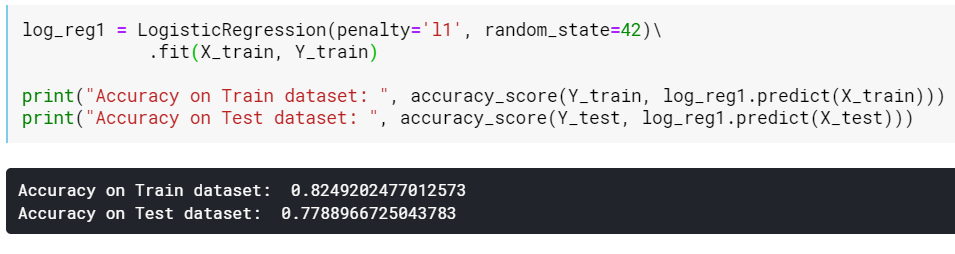

**The accuracy on Train dataset has decreased by about 1%. But, there is a similar (~1%) improvement in the accuracy on Test data**

In [ ]:
print("Test Data Classification Report:\n\n", classification_report(Y_test, log_reg_sig.predict(X_test)))

### Classification report from previous model
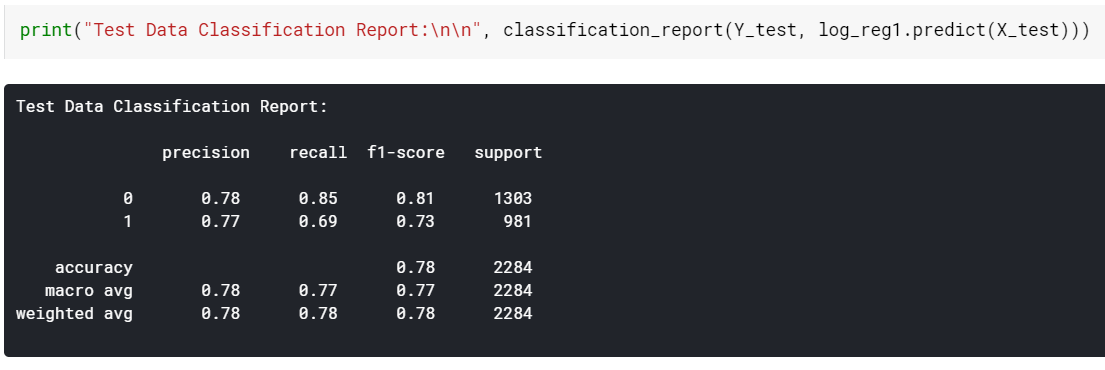

# Conclusions

* Accuracies above observed both improvement and decline in performace a bit. But, when we look at the f1-score for both the targets ('0' & '1') - they observed a slight improvement of 0.01.

* So, we can conclude that after removing the features from above mentioned technique there was no impact on the performance of the model and hence it can be used as one of the technique for Feature selection and in case where we have thousands of features it can definitely give a boost in training time without much impact on performace.

* I belive this can also work with continuous variables and I will definitely test it out on such data and will share the results back.

### Please share your thoughts and suggestions.